# Colombians migration data analysis

## librerías, carga de datos  y primera inspección

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Cargaremos el **conjunto de datos** (dataset) desde **PostgreSQL** para:

1.  Verificar si los datos requieren una **limpieza** adicional.
2.  Realizar un **Análisis Exploratorio de Datos (EDA)**.
3.  Responder preguntas específicas sobre la **migración colombiana** a través de **aeropuertos internacionales**, empleando **análisis y visualizaciones** en Python.

In [2]:
with open('../config.json') as f:
    config = json.load(f)
db = config["database"]

# Crear la conexión
engine = create_engine(
    f"postgresql://{db['user']}:{db['password']}@{db['host']}:{db['port']}/{db['dbname']}")

# Leer la tabla limpia desde PostgreSQL
df = pd.read_sql("SELECT * FROM registro_aeropuerto", engine, parse_dates=['fecha_de_registro'])

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   pais                   200000 non-null  object        
 1   codigo_iso_pais        200000 non-null  object        
 2   ciudad_de_residencia   200000 non-null  object        
 3   oficina_de_registro    200000 non-null  object        
 4   grupo_edad             200000 non-null  object        
 5   edad_anios             199719 non-null  float64       
 6   area_conocimiento      200000 non-null  object        
 7   sub_area_conocimiento  200000 non-null  object        
 8   nivel_academico        200000 non-null  object        
 9   estado_civil           200000 non-null  object        
 10  genero                 200000 non-null  object        
 11  etnia_de_la_persona    200000 non-null  object        
 12  estatura_cm            35658 non-null   floa

,pais,codigo_iso_pais,ciudad_de_residencia,oficina_de_registro,grupo_edad,edad_anios,area_conocimiento,sub_area_conocimiento,nivel_academico,estado_civil,genero,etnia_de_la_persona,estatura_cm,ciudad_de_nacimiento,fecha_de_registro,cantidad_de_personas,latitud,longitud
0,ESPAÑA,ESP,CATALU�A/BARCELONA,C. BARCELONA,ADULTOS,56.0,NINGUNA,NINGUNA,BACHILLERATO,CASADO,FEMENINO,NINGUNA,NaN,COLOMBIA/BOYACA/GARAGOA,2025-06-01,1,40.463667,-3.74922
1,ESPAÑA,ESP,MADRID/FUENLABRADA,C. MADRID,ADULTOS,38.0,NINGUNA,NINGUNA,NO INDICA,CASADO,MASCULINO,OTRO,NaN,VENEZUELA/MIRANDA/LOS TEQUES,2019-05-01,1,40.463667,-3.74922
2,VENEZUELA,VEN,CARABOBO/SAN DIEGO,C. VALENCIA VEN,ADULTOS,34.0,NO INDICA,NO INDICA,PREGRADO - PROFESIONAL,SOLTERO,MASCULINO,NINGUNA,180.0,VENEZUELA/CARABOBO/VALENCIA,2015-01-01,1,6.423750,-66.58973
3,ESPAÑA,ESP,CANTABRIA/SANTANDER,C. BILBAO,ADULTOS,30.0,NINGUNA,NINGUNA,NO INDICA,SOLTERO,MASCULINO,OTRO,NaN,COLOMBIA/TOLIMA/IBAGUE,2019-05-01,1,40.463667,-3.74922
4,ESPAÑA,ESP,MADRID/MADRID,C. MADRID,ADULTOS MAYORES,71.0,NINGUNA,NINGUNA,BACHILLERATO,VIUDO,FEMENINO,NINGUNA,NaN,COLOMBIA/CALDAS/CHINCHINA,2017-11-01,1,40.463667,-3.74922


## Limpieza de datos

Como primer paso de la limpieza de datos, observamos que las columnas **'edad_anios'** y **'estatura_cm'** no pudieron convertirse al tipo de dato **`int64`**, a diferencia de la columna **'cantidad_de_personas'**. Esto se debe a la presencia de **valores nulos** en algunas de sus filas.

Para resolver esto, realizaremos el siguiente proceso de **imputación**:

1. **Columna `edad_anios`:** Para imputar los valores nulos en esta columna, nos enfocaremos en la columna **'grupo_edad'**:

* Imputaremos los valores nulos con la **media de años** correspondiente a su respectivo grupo etario.
* Si el valor de **'grupo_edad'** es **'DESCONOCIDO'**, imputaremos el nulo con el valor **0**.

---

2. **Columna `estatura_cm`:** Para imputar los valores nulos en esta columna, consideraremos las columnas **'grupo_edad'** y **'genero'**, ya que la estatura puede variar significativamente entre géneros dentro del mismo grupo etario:

* Imputaremos los valores nulos con la **media de estatura** correspondiente a la combinación específica de **'grupo_edad'** y **'genero'**.
* Si el valor de **'grupo_edad'** o **'genero'** es **'DESCONOCIDO'**, imputaremos el nulo con el valor **0**.

---

3. **Cambio de Tipo de Dato:** Finalmente, una vez imputados los nulos, **cambiaremos el tipo de dato** de las columnas **'edad_anios'** y **'estatura_cm'** a **`int64`** para asegurar la consistencia del *dataset*.

In [3]:
df.groupby("grupo_edad")["edad_anios"].apply(lambda x: x.isnull().sum()).reset_index(name="nulls_edad_anios")

,grupo_edad,nulls_edad_anios
0,ADOLESCENCIA,0
1,ADULTOS,0
2,ADULTOS JOVENES,0
3,ADULTOS MAYORES,0
4,DESCONOCIDO,281
5,INFANCIA,0
6,PRIMERA INFANCIA,0


Hemos identificado que **todos los valores nulos** en la columna **'edad_anios'** corresponden al grupo etario **'DESCONOCIDO'**.

Por lo tanto, procederemos a **imputar todos esos nulos con el valor 0**.

In [4]:
df['edad_anios'] = df['edad_anios'].fillna(0)

print('Cantidad de filas con nulos transformados: ', df['edad_anios'].isnull().sum())

Cantidad de filas con nulos transformados:  0


In [5]:
df.groupby(['grupo_edad','genero'])['estatura_cm'].apply(lambda x: x.isnull().sum()).reset_index(name='nulls_estatura_cm')

,grupo_edad,genero,nulls_estatura_cm
0,ADOLESCENCIA,DESCONOCIDO,3
1,ADOLESCENCIA,FEMENINO,2028
2,ADOLESCENCIA,MASCULINO,2089
3,ADOLESCENCIA,NO_BINARIO,1
4,ADULTOS,DESCONOCIDO,75
5,ADULTOS,FEMENINO,56829
6,ADULTOS,MASCULINO,47701
7,ADULTOS JOVENES,DESCONOCIDO,10
8,ADULTOS JOVENES,FEMENINO,11958
9,ADULTOS JOVENES,MASCULINO,11867


Al revisar la tabla, notamos la presencia de **valores nulos** en la columna **'estatura_cm'**. Estos nulos pueden ser clasificados y tratados para **reducir su impacto** y mantener la integridad de los datos.

Por lo tanto, procederemos a la **imputación** de la siguiente manera:

* Calcularemos la **media de la estatura** (`estatura_cm`) para cada **combinación única de 'grupo_edad' y 'genero'**.
* Imputaremos los valores nulos de `estatura_cm` con la media correspondiente a su respectivo grupo.

De esta forma, aprovechamos la influencia del **género** en la estatura dentro de cada **grupo etario** para realizar una imputación más precisa.

In [6]:
df_filtrado = df[(df['grupo_edad'] != 'DESCONOCIDO') & (df['genero'] != 'DESCONOCIDO') & (df['estatura_cm'].notnull())]

resultado = ( df_filtrado.groupby(['grupo_edad', 'genero'])['estatura_cm'].mean().round()
    .reset_index(name='media_estatura_cm'))

display(resultado)
print('Cantidad de filas con nulos:', df['estatura_cm'].isnull().sum())

#Imputacion de la media a datos null
df['estatura_cm'] = df['estatura_cm'].fillna(
    df.groupby(['grupo_edad', 'genero'])['estatura_cm'].transform('mean').round())

print('Cantidad de filas con nulos restantes: ', df['estatura_cm'].isnull().sum())

,grupo_edad,genero,media_estatura_cm
0,ADOLESCENCIA,FEMENINO,110.0
1,ADOLESCENCIA,MASCULINO,111.0
2,ADULTOS,FEMENINO,161.0
3,ADULTOS,MASCULINO,173.0
4,ADULTOS JOVENES,FEMENINO,155.0
5,ADULTOS JOVENES,MASCULINO,162.0
6,ADULTOS MAYORES,FEMENINO,159.0
7,ADULTOS MAYORES,MASCULINO,170.0
8,INFANCIA,FEMENINO,75.0
9,INFANCIA,MASCULINO,80.0


Cantidad de filas con nulos: 164342
Cantidad de filas con nulos restantes:  808


In [7]:
df['estatura_cm'] = df['estatura_cm'].fillna(0)
print('Cantidad de filas con nulos: ', df['estatura_cm'].isnull().sum())

Cantidad de filas con nulos:  0


Una vez finalizado el proceso de **imputación de todos los valores nulos**, procederemos con los siguientes pasos:

1.  **Cambio de Tipo de Dato:** Modificaremos el tipo de dato de las columnas **'edad_anios'** y **'estatura_cm'** al formato **`int64`** para asegurar la consistencia numérica.
2.  **Copia del *Dataset*:** Crearemos una **copia de este *dataset* ya limpio** (o transformado). Esta copia servirá como la base de datos final para iniciar el **Análisis Exploratorio de Datos (EDA)** y las visualizaciones.

In [8]:
df['edad_anios'] = df['edad_anios'].astype('int64')
df['estatura_cm'] = df['estatura_cm'].astype('int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   pais                   200000 non-null  object        
 1   codigo_iso_pais        200000 non-null  object        
 2   ciudad_de_residencia   200000 non-null  object        
 3   oficina_de_registro    200000 non-null  object        
 4   grupo_edad             200000 non-null  object        
 5   edad_anios             200000 non-null  int64         
 6   area_conocimiento      200000 non-null  object        
 7   sub_area_conocimiento  200000 non-null  object        
 8   nivel_academico        200000 non-null  object        
 9   estado_civil           200000 non-null  object        
 10  genero                 200000 non-null  object        
 11  etnia_de_la_persona    200000 non-null  object        
 12  estatura_cm            200000 non-null  int6

In [9]:
df_processing = df.copy()

## Inicio del Análisis Exploratorio de Datos

### Análisis univariable

Tras completar la carga y **limpieza de los datos**, el objetivo principal de esta fase es extraer **información relevante** para entender los patrones de viaje.

Comenzaremos el análisis exploratorio examinando el comportamiento de **variables individuales** que puedan ser relevantes por sí solas, como la **columna de país de destino**. A partir de este análisis inicial, desarrollaremos la investigación para identificar los flujos migratorios más importantes.

Nos enfocaremos en analizar las **características clave** del *dataset* para identificar los factores que influyen en la elección del **destino** por parte de los colombianos.

Este análisis nos permitirá:

* Descubrir **por qué** ciertas personas viajan con más frecuencia o prefieren un destino sobre otro (por ejemplo: por edad, género, o mes del año).
* Generar **visualizaciones de datos** (gráficos) que ilustren de forma clara y concisa las distribuciones y las correlaciones encontradas.

Con esto, podremos empezar a **responder preguntas específicas** sobre la migración colombiana al exterior.

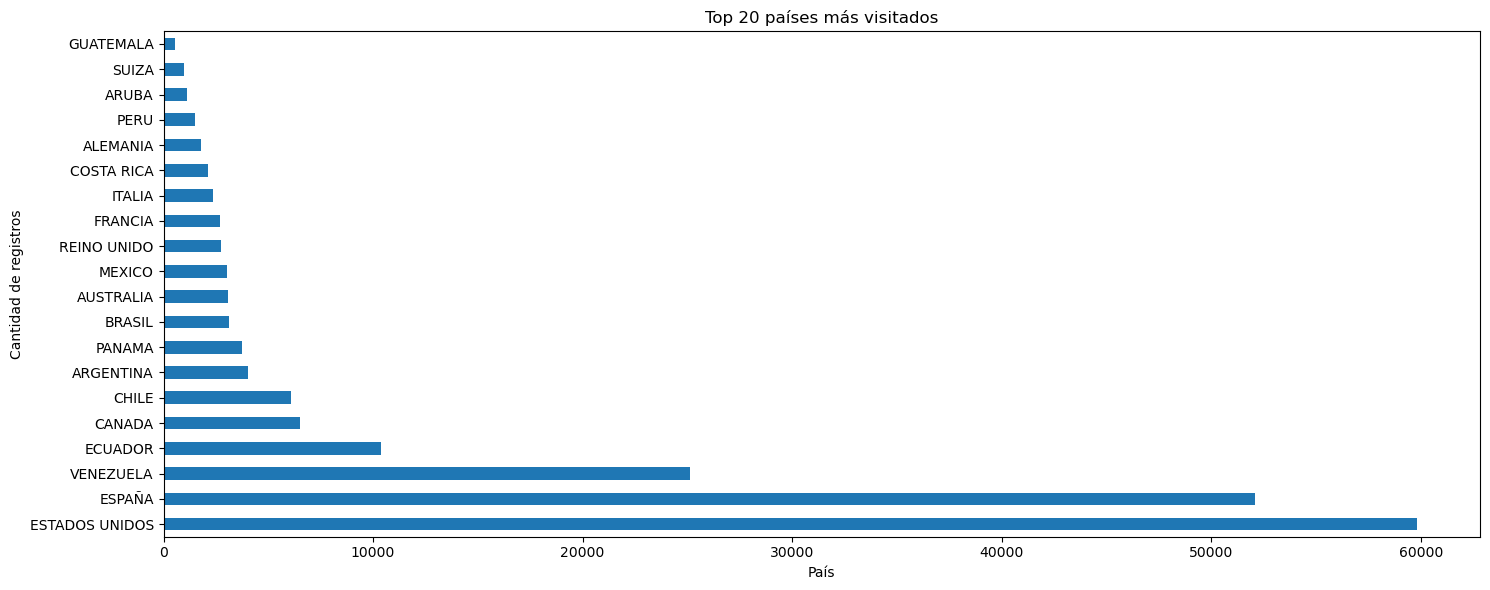

In [90]:
top_20_paises = df_processing['pais'].value_counts().head(20)

plt.figure(figsize=(15, 6))
top_20_paises.plot(kind='barh')

plt.title('Top 20 países más visitados')
plt.xlabel('País')
plt.ylabel('Cantidad de registros')
plt.tight_layout()
plt.show()

Como parte del análisis de **variables individuales**, se presenta la tabla con los **20 países más visitados** por los viajeros colombianos para obtener un contexto inicial.

Esta exploración **confirma** los hallazgos de las consultas previas de **SQL**, mostrando que los tres destinos más frecuentados son, por orden:

1.  **Estados Unidos**
2.  **España**
3.  **Venezuela**

A continuación, iniciaremos la exploración de la columna **'grupo_edad'**. El objetivo es determinar **qué grupos etarios tienen la mayor propensión a viajar al exterior**, independientemente de su destino. Al analizar la distribución, podremos identificar qué **tipo de personas (por rango de edad)** concentran el mayor flujo migratorio colombiano.

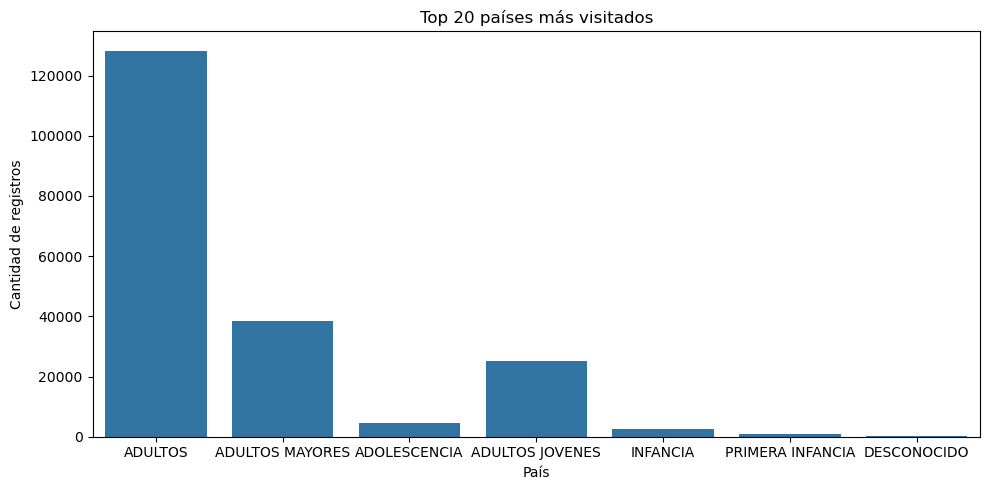

In [91]:
plt.figure(figsize=(10, 5))
sns.countplot(data = df_processing, x ='grupo_edad')

plt.title('Top 20 países más visitados')
plt.xlabel('País')
plt.ylabel('Cantidad de registros')
plt.tight_layout()
plt.show()

El análisis univariado de la columna **'grupo_edad'** confirma que los tres grupos de adultos ('ADULTOS', 'ADULTOS MAYORES' y 'ADULTOS JOVENES') concentran la mayor parte de los viajes al exterior. El grupo **'ADULTOS'** destaca significativamente, superando con creces a las demás categorías.

Este dato nos permite inferir que las **personas en edad productiva y avanzada** son, en general, las que más se desplazan al exterior.

A partir de este hallazgo, surge una pregunta clave sobre la **motivación** detrás de estos viajes:

* ¿Los adultos viajan al exterior porque obtuvieron una **mejor oportunidad laboral** (sugiriendo alta formación)?
* O, por el contrario, ¿viajan por la **falta de oportunidades** en el país de origen debido a la **escasa formación académica**?

Para responder a esta hipótesis, el siguiente paso será analizar la columna **'nivel_academico'** en conjunto con la de 'grupo_edad' para determinar la relación entre la formación del viajero y su propensión a emigrar.

In [35]:
df_processing.head()

,pais,codigo_iso_pais,ciudad_de_residencia,oficina_de_registro,grupo_edad,edad_anios,area_conocimiento,sub_area_conocimiento,nivel_academico,estado_civil,genero,etnia_de_la_persona,estatura_cm,ciudad_de_nacimiento,fecha_de_registro,cantidad_de_personas,latitud,longitud
0,ESPAÑA,ESP,CATALU�A/BARCELONA,C. BARCELONA,ADULTOS,56,NINGUNA,NINGUNA,BACHILLERATO,CASADO,FEMENINO,NINGUNA,161,COLOMBIA/BOYACA/GARAGOA,2025-06-01,1,40.463667,-3.74922
1,ESPAÑA,ESP,MADRID/FUENLABRADA,C. MADRID,ADULTOS,38,NINGUNA,NINGUNA,NO INDICA,CASADO,MASCULINO,OTRO,173,VENEZUELA/MIRANDA/LOS TEQUES,2019-05-01,1,40.463667,-3.74922
2,VENEZUELA,VEN,CARABOBO/SAN DIEGO,C. VALENCIA VEN,ADULTOS,34,NO INDICA,NO INDICA,PREGRADO - PROFESIONAL,SOLTERO,MASCULINO,NINGUNA,180,VENEZUELA/CARABOBO/VALENCIA,2015-01-01,1,6.423750,-66.58973
3,ESPAÑA,ESP,CANTABRIA/SANTANDER,C. BILBAO,ADULTOS,30,NINGUNA,NINGUNA,NO INDICA,SOLTERO,MASCULINO,OTRO,173,COLOMBIA/TOLIMA/IBAGUE,2019-05-01,1,40.463667,-3.74922
4,ESPAÑA,ESP,MADRID/MADRID,C. MADRID,ADULTOS MAYORES,71,NINGUNA,NINGUNA,BACHILLERATO,VIUDO,FEMENINO,NINGUNA,159,COLOMBIA/CALDAS/CHINCHINA,2017-11-01,1,40.463667,-3.74922
